In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

In [219]:
train_df = pl.read_csv('C:/Users/ludkov-as/repo/train.csv')

### **train.csv**
- **row_id: ***(int64)***** - ID строки
- **timestamp: ***(int64)***** - время в мс между взаимодействием пользователя и первым завершением события от этого пользователя
- **user_id: ***(int32)***** - ID пользователя
- **content_id: ***(int16)***** - ID взаимодействия пользователя
- **content_type_id: ***(int8)***** *0*, - если событие является вопросом, заданным пользователю, *1*, если событием было посещение пользователем лекции
- **task_container_id: ***(int16)***** - ID группы вопросов или лекций. Например, пользователь может увидеть три вопроса подряд, прежде чем получить объяснения для какого-либо из них. Все эти три вопроса будут иметь общий *task_container_id*
- **user_answer: ***(int8)***** - ответ пользователя на вопрос, если таковой имеется. *-1* как *null* для лекций
- **answered_correctly: ***(int8)***** - если пользователь ответил правильно. Читать *-1* как *null* для лекций
- **prior_question_elapsed_time: ***(float32)***** - Среднее время в мс, которое потребовалось пользователю для ответа на каждый вопрос в предыдущей группе вопросов, игнорируя любые лекции между ними. Имеет значение *null* для первой группы вопросов или лекции пользователя. Обратите внимание, что время — это среднее время, которое потребовалось пользователю для решения каждого вопроса в предыдущей группе
- **prior_question_had_explanation: ***(bool)***** - Увидел ли пользователь объяснение и правильный ответ после ответа на предыдущую группу вопросов, игнорируя любые лекции между ними. Значение является общим для одной группы вопросов и имеет значение *null* для первой группы вопросов или лекции пользователя. Обычно первые несколько вопросов, которые видит пользователь, являются частью диагностического теста при вступлении, в ходе которого он не получал никакой обратной связи

In [220]:
# По умолчанию polars присваивает всем столбцам с числовыми значениями типы int64 и float64, 
# поэтому для экономии памяти скорректируем типы в соответствии с вышеприведённым описанием столбцов
train_df = train_df.cast({
    "user_id": pl.Int32,
    "content_id": pl.Int16,
    "content_type_id": pl.Int8,
    "task_container_id": pl.Int16,
    "user_answer": pl.Int8,
    "answered_correctly": pl.Int8,
    "prior_question_elapsed_time": pl.Float32
})

In [ ]:
# Заполним отсутствующие значения
train_df = train_df.fill_null(0).fill_null(False)

In [382]:
# Отобразить часть датасета
train_df

row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
i64,i64,i32,i16,i8,i16,i8,i8,f32,bool
0,0,115,5692,0,1,3,1,0.0,false
1,56943,115,5716,0,2,2,1,37000.0,false
2,118363,115,128,0,0,0,1,55000.0,false
3,131167,115,7860,0,3,0,1,19000.0,false
4,137965,115,7922,0,4,1,1,11000.0,false
…,…,…,…,…,…,…,…,…,…
101230327,428564420,2147482888,3586,0,22,0,1,18000.0,true
101230328,428585000,2147482888,6341,0,23,3,1,14000.0,true
101230329,428613475,2147482888,4212,0,24,3,1,14000.0,true


In [224]:
# Получить число строк
train_df_rows = train_df.shape[0]
train_df_rows

101230332

- #### **content_type_id**. Проверка корректности данных и анализ связей со столбцами user_answer и answered_correctly

In [ ]:
# Проверим уникальные значения столбца content_type_id
# В соответствии с описанием в столбце должны присутствовать только значения 0 и 1
list(train_df.unique(subset='content_type_id')['content_type_id'])

[0, 1]

Количество вопросов/лекций в столбце content_type_id: 99271300 / 1959032
Процент вопросов от общего числа строк: 0.9806477765972357


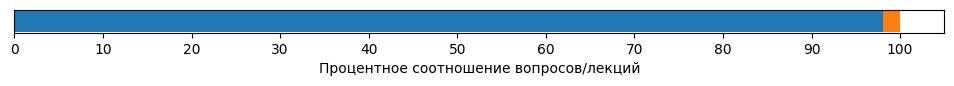

In [171]:
# Получим количество вопросов и лекций из общего числа строк столбца content_type_id
questions_num = train_df.filter(pl.col('content_type_id') == 0).shape[0]
questions_f = questions_num / train_df.shape[0]
print(f"Количество вопросов/лекций в столбце content_type_id: {questions_num} / {train_df_rows - questions_num}\nПроцент вопросов от общего числа строк: {questions_f}")

# Построим график процентного соотношения
prop1 = 100 * questions_num / (questions_num + (train_df_rows - questions_num))
prop2 = 100 * (train_df_rows - questions_num) / (questions_num + (train_df_rows - questions_num))

fig, ax = plt.subplots()
ax.barh(y=0, width=prop1, left=0)
ax.barh(y=0, width=prop2, left=prop1)

fig.set_size_inches(12, 0.3)
ax.yaxis.set_visible(False)
ax.set_xticks(np.linspace(0, 100, 11))
ax.set_xlabel('Процентное соотношение вопросов/лекций')

plt.show()

In [11]:
# Проверим наличие ошибочных данных:
# существуют ли для вопросов из столбца content_type_id значения для лекций в столбце user_answer
train_df.filter((pl.col('content_type_id') == 0) & (pl.col('user_answer') == -1)).shape[0]

0

In [12]:
# Аналогичным образом проверим значения столбца answered_correctly
train_df.filter((pl.col('content_type_id') == 0) & (pl.col('answered_correctly') == -1)).shape[0]

0

In [203]:
# Дополнительно выведем несколько строк таблицы с обоими возможными типами данных столбца для удобства дальнейшего анализа
display(train_df.filter(pl.col('content_type_id') == 0).head(5))
display(train_df.filter(pl.col('content_type_id') == 1).head(5))

row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
i64,i64,i32,i16,i8,i16,i8,i8,f32,bool
0,0,115,5692,0,1,3,1,0.0,null
1,56943,115,5716,0,2,2,1,37000.0,false
2,118363,115,128,0,0,0,1,55000.0,false
3,131167,115,7860,0,3,0,1,19000.0,false
4,137965,115,7922,0,4,1,1,11000.0,false


row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
i64,i64,i32,i16,i8,i16,i8,i8,f32,bool
89,653762,2746,6808,1,14,-1,-1,0.0,false
117,10183847,5382,16736,1,21,-1,-1,0.0,false
212,1424348597,5382,30207,1,104,-1,-1,0.0,false
216,1425557777,5382,18545,1,121,-1,-1,0.0,false
295,405813029,8623,10540,1,59,-1,-1,0.0,false


- #### **task_container_id**. Анализ количества групп, соотношение вопросов и лекций

In [59]:
# Для начала получим общее количество существующих групп вопросов/лекций
groups_num = train_df.unique(subset='task_container_id')['task_container_id'].shape[0]
groups_num

10000

In [66]:
# Определим среднее соотношение вопросов и лекций в рамках одной группы
# Для этого используем ранее полученный процент вопросов в рамках всего датасета
questions_num_group = round((train_df_rows / groups_num) * questions_f)
lectures_num_group = round((train_df_rows / groups_num) * (1 - questions_f))
print(f"Среднее соотношение вопросов/лекций в рамках одной группы: {questions_num_group}/{lectures_num_group}")
print(f"Среднее процентное соотношение: {questions_num_group/groups_num}/{lectures_num_group/groups_num}")

Среднее соотношение вопросов/лекций в рамках одной группы: 9927/196
Среднее процентное соотношение: 0.9927/0.0196


- #### **answered_correctly**. Процент корректных ответов на вопросы от их общего числа

In [54]:
# Получим процентое сооотношение правильно отвеченных вопросов от общего числа вопросов в датасете
correct_answers = train_df.filter(pl.col('answered_correctly') == 1).shape[0]
correct_answers / questions_num

0.6572355454194717

- #### **prior_question_elapsed_time**. Среднее время ответа на вопрос, график распределения

In [7]:
# Получим среднее время, затраченное пользователем на ответ
train_df.select(pl.col('prior_question_elapsed_time')).mean()

prior_question_elapsed_time
f32
25423.810547


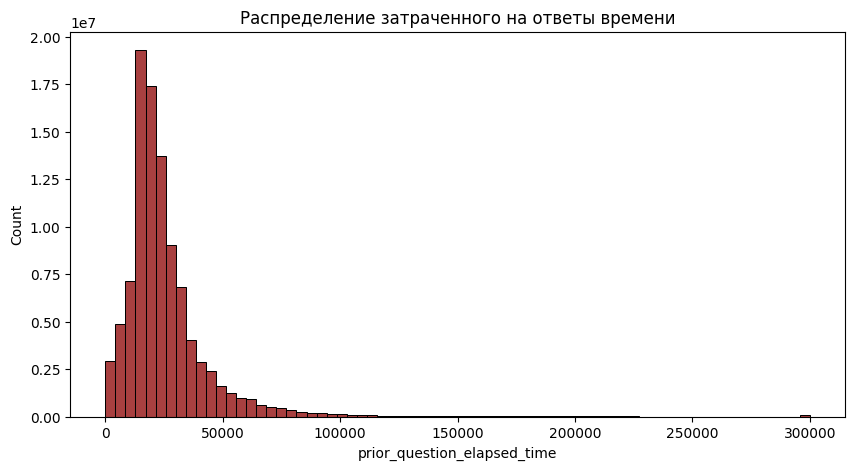

In [6]:
# Построим график распределения затраченного на ответы времени
plt.figure(figsize=(10, 5))
plt.title("Распределение затраченного на ответы времени")
sns.histplot(
    data=train_df.select('prior_question_elapsed_time'),
    x="prior_question_elapsed_time",
    bins=70,
    color="darkred" 
)
plt.show()

- #### **prior_question_elapsed_time**. Распределение успешности ответов от затраченного на них времени

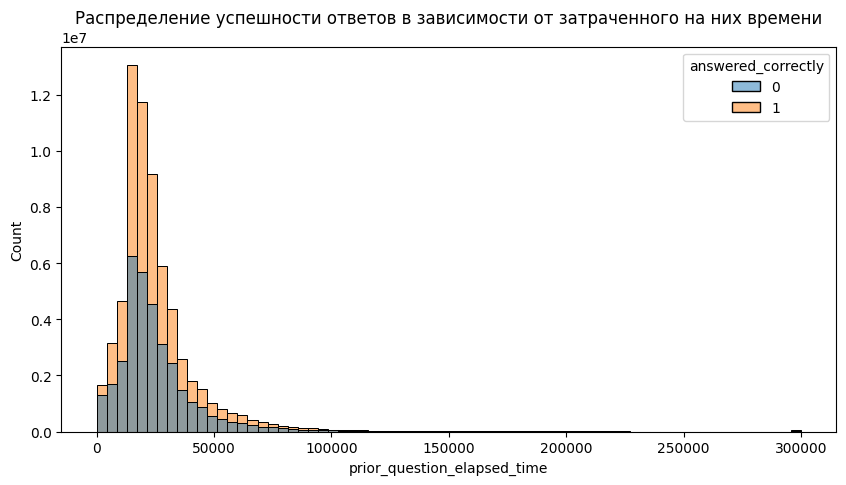

In [ ]:
# Построим график распределения answered_correctly в зависимости от prior_question_elapsed_time
plt.figure(figsize=(10, 5))
plt.title("Распределение успешности ответов в зависимости от затраченного на них времени")
sns.histplot(
    data=train_df.filter(pl.col('answered_correctly') != -1).select(['prior_question_elapsed_time', 'answered_correctly']),
    x="prior_question_elapsed_time",
    bins=70,
    hue="answered_correctly" 
)
plt.show()

- #### **prior_question_had_explanation**. Влияние посещения лекций на правильность ответов

Построим две гистограммы. Получим общее число правильных ответов на все вопросы в двух фильтрациях - при посещении не непосещении лекций. 

Процент правильных ответов: 4.6361828645338585


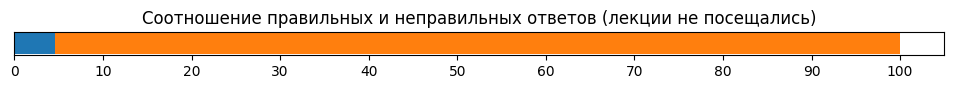

In [18]:
# Общее число правильных ответов, если лекции не посещались
correct_ans_without_explain = train_df.filter((pl.col('prior_question_had_explanation') == False) & (pl.col('answered_correctly') == 1)).shape[0]

# Построим график процентного соотношения
prop1 = 100 * correct_ans_without_explain / (correct_ans_without_explain + (questions_num - correct_ans_without_explain))
prop2 = 100 * (questions_num - correct_ans_without_explain) / (correct_ans_without_explain + (questions_num - correct_ans_without_explain))

print(f"Процент правильных ответов: {prop1}")

fig, ax = plt.subplots()
plt.title("Соотношение правильных и неправильных ответов (лекции не посещались)")
ax.barh(y=0, width=prop1, left=0)
ax.barh(y=0, width=prop2, left=prop1)
fig.set_size_inches(12, 0.3)
ax.yaxis.set_visible(False)
ax.set_xticks(np.linspace(0, 100, 11))
plt.show()

Процент правильных ответов: 60.81847220697221


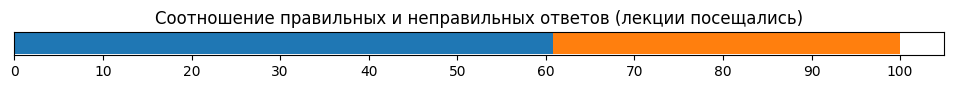

In [17]:
# Общее число правильных ответов, если лекции посещались
correct_ans_with_explain = train_df.filter((pl.col('prior_question_had_explanation') == True) & (pl.col('answered_correctly') == 1)).shape[0]

# Построим график процентного соотношения
prop1 = 100 * correct_ans_with_explain / (correct_ans_with_explain + (questions_num - correct_ans_with_explain))
prop2 = 100 * (questions_num - correct_ans_with_explain) / (correct_ans_with_explain + (questions_num - correct_ans_with_explain))

print(f"Процент правильных ответов: {prop1}")

fig, ax = plt.subplots()
plt.title("Соотношение правильных и неправильных ответов (лекции посещались)")
ax.barh(y=0, width=prop1, left=0)
ax.barh(y=0, width=prop2, left=prop1)
fig.set_size_inches(12, 0.3)
ax.yaxis.set_visible(False)
ax.set_xticks(np.linspace(0, 100, 11))
plt.show()

Для определения успеваемости студентов от количества посещённых ими лекций создадим новый датасет **performance_df**:
- определим основную группировку по *user_id* и временно укажем столбцу строковый тип данных для суммирования параметров;
- изменим значения -1 столбца *answered_correctly* для получения корректной суммы правильных ответов;
- создадим новый столбец *questions_num* на основе данных *content_type_id* (лекции не являются ответами на вопросы и не должны попасть в итоговую сумму вопросов);
- переименуем *content_type_id* в *lectures_num* (после суммирования этот столбец будет отображать общее число лекций, посещённых студентом);
- просуммируем значения столбцов и переопределим типы параметров нового датасета.

Включение в новый датасет столбца *prior_question_elapsed_time* позволит соотнести число отвеченных студентом вопросов с суммарным временем на их решение, а параметр *performance* позволит оценить успеваемость каждого студента в отдельности.

In [398]:
performance_df = train_df.select(['user_id', 'content_type_id', 'answered_correctly', 'prior_question_elapsed_time'])\
    .cast({"user_id": pl.String})\
    .with_columns(pl.when(pl.col('answered_correctly') == -1).then(0).otherwise(pl.col('answered_correctly')).alias('answered_correctly'))\
    .with_columns(pl.when(pl.col('content_type_id') == 1).then(0).otherwise(1).alias("questions_num"))\
    .rename({'content_type_id': 'lectures_num'})\
    .group_by('user_id').sum()\
    .with_columns((pl.col('answered_correctly') / pl.col('questions_num')).alias('performance'))\
    .cast({
        'user_id': pl.Int64, 
        'answered_correctly': pl.Int16, 
        'lectures_num': pl.Int16, 
        'questions_num': pl.Int16,
        'prior_question_elapsed_time': pl.UInt32,
        'performance': pl.Float32
        })\
    .filter(pl.col('prior_question_elapsed_time') > 0)

In [400]:
# Выведем часть полученного датасета
performance_df

user_id,lectures_num,answered_correctly,prior_question_elapsed_time,questions_num,performance
i64,i16,i16,u32,i16,f32
253322173,4,114,3498000,163,0.699386
1255408165,0,29,1376000,55,0.527273
1410989961,0,15,343000,21,0.714286
1821377682,0,23,1165000,40,0.575
428434087,2,131,3193000,185,0.708108
…,…,…,…,…,…
1059258706,0,6,673996,30,0.2
642496279,0,46,1518913,70,0.657143
1553769067,0,6,367000,13,0.461538


Ранее нами было получено соотношение вопросов и лекций в основном датасете **train_df** в виде переменной *questions_f*. Проверим следующую гипотезу - соотношение средних значений столбцов *questions_num* и *lectures_num* должно соответствовать *questions_f*. 

In [401]:
perf_df_lectures_f, perf_df_questions_f = performance_df.select(['lectures_num', 'questions_num']).mean()
abs((perf_df_lectures_f.to_list()[0] / perf_df_questions_f.to_list()[0]) - (1 - questions_f))

0.0003820128407296883

Погрешность полученного значения невелика, поэтому можем считать, что гипотеза верна.

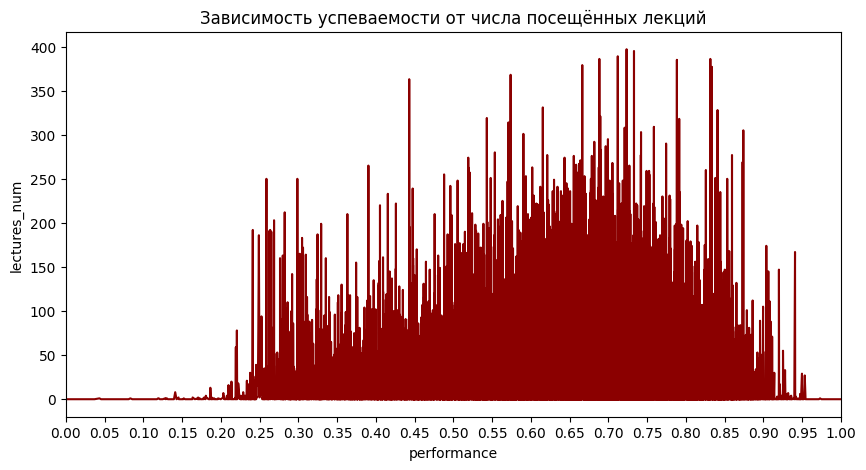

In [402]:
# Построим график зависимости успеваемости студентов (процента правильных ответов) от числа посещённых ими лекций
plt.figure(figsize=(10, 5))
plt.title("Зависимость успеваемости от числа посещённых лекций")
sns.lineplot(
    data=performance_df.unique(subset='performance'), 
    x="performance", 
    y="lectures_num",
    color="darkred",
    )
plt.xlim(0, 1)
plt.xticks(np.arange(0, 1.05, 0.05))
plt.show()

Для интеграции **train_df** с **questions_df** и **lectures_df** создадим облегчённый датасет **content_expand_df** на базе **train_df**. По аналогии с **performance_df** в нём будут представлены суммарные значения лекций, вопросов и правильных на них ответов, однако первичная фильтрация осуществится по значениям параметра *content_id*, что позволит в дальнейшем объединить данные нескольких таблиц.

In [238]:
content_expand_df = train_df.select(['content_id', 'content_type_id', 'answered_correctly'])\
    .cast({"content_id": pl.String})\
    .with_columns(pl.when(pl.col('answered_correctly') == -1).then(0).otherwise(pl.col('answered_correctly')).alias('answered_correctly'))\
    .with_columns(pl.when(pl.col('content_type_id') == 1).then(0).otherwise(1).alias("questions_num"))\
    .rename({'content_type_id': 'lectures_num'})\
    .group_by('content_id').sum()\
    .with_columns((pl.col('answered_correctly') / pl.col('questions_num')).alias('performance'))\
    .cast({
        'content_id': pl.Int16,
        'answered_correctly': pl.Int32,
        'lectures_num': pl.Int32,
        'performance': pl.Float32
        })\
    .fill_nan(0)

In [383]:
# Отобразим часть полученного датасета
content_expand_df.sort(by='content_id', descending=False)

content_id,lectures_num,answered_correctly,questions_num,performance
i16,i32,i32,i32,f32
0,0,6266,6903,0.907721
1,0,6589,7398,0.890646
2,0,24890,44905,0.554281
3,0,17906,22973,0.779437
4,0,19461,31736,0.613215
…,…,…,…,…
32535,3666,0,0,0.0
32570,2910,0,0,0.0
32604,4,0,0,0.0


### **questions.csv**: метаданные для вопросов, заданных пользователям.
- **question_id** - внешний ключ для столбца *content_id* обучения/тестирования, когда тип контента — *вопрос (0)*
- **bundle_id** - код, для которого вопросы обслуживаются вместе
- **correct_answer** - ответ на вопрос. Можно сравнить со столбцом *user_answer* обучения, чтобы проверить, был ли пользователь прав
- **part** - соответствующий раздел теста TOEIC
- **tags** - один или несколько подробных кодов тегов для вопроса. Значение тегов не будет предоставлено, но этих кодов достаточно для кластеризации вопросов вместе

In [134]:
questions_df = pl.read_csv('C:/Users/ludkov-as/repo/questions.csv')

In [ ]:
# Скорректируем типы данных датасета
questions_df = questions_df.cast({
    "question_id": pl.Int16,
    "bundle_id": pl.Int16,
    "correct_answer": pl.Int8,
    "part": pl.Int16
})

In [404]:
# Отобразить часть датасета
questions_df.drop_nulls()

question_id,bundle_id,correct_answer,part,tags
i16,i16,i8,i16,str
0,0,0,1,"""51 131 162 38"""
1,1,1,1,"""131 36 81"""
2,2,0,1,"""131 101 162 92"""
3,3,0,1,"""131 149 162 29"""
4,4,3,1,"""131 5 162 38"""
…,…,…,…,…
13518,13518,3,5,"""14"""
13519,13519,3,5,"""8"""
13520,13520,2,5,"""73"""


In [137]:
# Проверить уникальные значения столбца correct_answer
list(questions_df.unique(subset='correct_answer')['correct_answer'])

[0, 3, 1, 2]

In [341]:
# Объединим content_expand_df и questions_df
questions_expand_df = content_expand_df.join(questions_df.rename({'question_id': 'content_id'}), on='content_id', how='inner').drop_nulls()
questions_expand_df

content_id,lectures_num,answered_correctly,questions_num,performance,bundle_id,correct_answer,part,tags
i16,i32,i32,i32,f32,i16,i8,i16,str
3214,0,4739,8759,0.541044,3213,3,4,"""82 67 81"""
3090,0,4098,5246,0.781167,3090,0,4,"""74 12 29"""
3587,0,1626,2234,0.727842,3587,1,5,"""8"""
435,0,14582,17993,0.810426,435,3,2,"""2 119 38 92"""
9756,0,3095,4422,0.69991,9756,0,5,"""96"""
…,…,…,…,…,…,…,…,…
11835,0,788,938,0.840085,11833,0,3,"""157 38 81"""
8003,0,4006,4652,0.861135,8003,3,5,"""55"""
7132,0,535,604,0.885762,7132,1,7,"""118 42 21"""


In [380]:
# Проанализируем наличие зависимости средних значений успеваемости и количества вопросов от тегов вопросов
display(questions_expand_df.select(['tags', 'performance']).group_by('tags').mean().sort(by='tags', descending=False).head())
display(questions_expand_df.select(['tags', 'questions_num']).group_by('tags').sum().sort(by='tags', descending=False).head())

tags,performance
str,f32
"""1""",0.629183
"""1 162""",0.675019
"""10 111 92""",0.837507
"""10 164 102""",0.761476
"""10 164 162 29""",0.879346


tags,questions_num
str,i32
"""1""",2264097
"""1 162""",145412
"""10 111 92""",7188
"""10 164 102""",18778
"""10 164 162 29""",12051


Сгруппировав информацию по тегам, можно констатировать отсутствие линейной зависимости значений тегов как от усреднённой успеваемости, так и от общего числа вопросов, соответствующих этим тегам.

In [363]:
# Определим среднюю успеваемость студентов для каждой группы вопросов (part)
# Отсортируем полученные значения в порядке убывания успеваемости
questions_expand_df.select(['part', 'performance']).group_by('part').mean().sort(by='performance', descending=True)

part,performance
i16,f64
1,0.815104
2,0.745296
3,0.744599
4,0.724918
7,0.717958
6,0.699348
5,0.666118


### **lectures.csv**: метаданные для лекций, просмотренных пользователями по мере их продвижения в образовании.
- **lecture_id** - внешний ключ для обучающего/тестового столбца *content_id*, когда тип контента — *lecture (1)*
- **part** - код категории верхнего уровня для лекции
- **tag** - один код тега для лекции. Значение тегов не будет предоставлено, но этих кодов достаточно для кластеризации лекций вместе
- **type_of** - краткое описание основной цели лекции

In [194]:
lectures_df = pl.read_csv('C:/Users/ludkov-as/repo/lectures.csv')

In [195]:
# Скорректируем типы данных датасета
lectures_df = lectures_df.cast({
    "lecture_id": pl.Int16,
    "tag": pl.Int16,
    "part": pl.Int8
})

In [385]:
# Отобразить часть датасета
lectures_df

lecture_id,tag,part,type_of
i16,i16,i8,str
89,159,5,"""concept"""
100,70,1,"""concept"""
185,45,6,"""concept"""
192,79,5,"""solving question"""
317,156,5,"""solving question"""
…,…,…,…
32535,8,5,"""solving question"""
32570,113,3,"""solving question"""
32604,24,6,"""concept"""


In [379]:
# Объединим content_expand_df и lectures_df
lectures_expand_df = content_expand_df.join(lectures_df.rename({'lecture_id': 'content_id'}), on='content_id', how='inner').drop_nulls()
lectures_expand_df.head()

content_id,lectures_num,answered_correctly,questions_num,performance,tag,part,type_of
i16,i32,i32,i32,f32,i16,i8,str
22362,11043,0,0,0.0,73,5,"""concept"""
3255,9703,2902,3130,0.927157,60,5,"""concept"""
6948,828,1880,2595,0.72447,127,5,"""solving question"""
89,10695,12683,13773,0.92086,159,5,"""concept"""
32023,1528,0,0,0.0,69,2,"""solving question"""


In [364]:
# Проанализируем среднюю успеваемость студентов по типам лекций (type_of)
# Отсортируем полученные значения в порядке убывания успеваемости
lectures_expand_df.select(['type_of', 'performance']).group_by('type_of').mean().sort(by='performance', descending=True)

type_of,performance
str,f32
"""intention""",0.455434
"""solving question""",0.269466
"""concept""",0.261202
"""starter""",0.181903


In [365]:
# Проанализируем среднюю успеваемость студентов по группам лекций (part)
# Отсортируем полученные значения в порядке убывания успеваемости
lectures_expand_df.select(['part', 'performance']).group_by('part').mean().sort(by='performance', descending=True)

part,performance
i8,f32
1,0.300983
5,0.300577
4,0.269586
7,0.268065
6,0.231367
3,0.22734
2,0.216239


### Заключение
В настоящей работе было проанализировано три датасета: **train_df**, **questions_df** и **lectures_df**. Во всех датасетах были заменены отсутствующие значения (*null*). По результатам проведённого анализа можно сформировать следующие выводы:

**train_df**
- в таблице представлена информация о **393656** студентах (*user_id*);
- в таблице суммарно **99271300** вопросов и **1959032** лекций (**98%** и **2%** от общего числа строк соответственно), а также **10000** групп вопросов/лекций (*task_container_id*);
- ошибочные данные отсутствуют (всё соответствует описанию датасета);
- процент корректных ответов на вопросы от их общего числа - **65,7%** (*answered_correctly*);
- среднее время ответа на вопрос - **25423.810547** (*prior_question_elapsed_time*);
- процентное соотношение правильных ответов при непосещении/посещении лекций студентами - **4,63%** / **60,82%** (*prior_question_had_explanation*);
- успеваемость студентов (параметр *performance* датасета **performance_df**, полученного из **train_df**) имеет зависимость от числа посещённых ими лекций - в целом, посещение большего числа лекций повышает успеваемость.

**questions_df**
- в таблице представлена информация о **13522** возможных вопросах (*question_id*);
- теги вопросов (*tags*) не имеют непосредственного влияния на успеваемость; 
- в таблице приведено **7** групп вопросов (*part*); лучший результат студенты показали при решении **1 группы** (**82%**), хуже - при решении **5 группы** (**67%**).

**lectures_df**
- в таблице представлена информация о **418** возможных лекциях (*lecture_id*);
- в таблице приведены **4** темы лекций (*type_of*) - *intension*, *solving question*, *concept* и *starter*. Наибольшее влияние на успеваемость оказала тема **intension** (**45%**), наименьшее - **starter** (**18%**);
- в таблице представлены **7** групп лекций (*part*). Наилучшая успеваемость соответствует **1 группе** (**30%**), наихудшая - **2 группе** (**22%**).